### Import libraries.

In [1]:
import pandas as pd
import re
import matplotlib.pyplot as plt
from tabulate import tabulate
from nltk.corpus import stopwords

from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

### Read in the clean data.

In [2]:
pd.set_option('display.max_columns', 1_000)
pd.set_option('display.max_rows', 1_000)

In [3]:
df = pd.read_csv('../data/subreddits.csv')

In [4]:
df.shape

(1972, 9)

In [5]:
df.head(1)

,title,selftext,class_target,text,title_char_count,title_word_count,selftext_char_count,selftext_word_count,flair
0,My 2yo doesn’t like the potty.,Hey!\n\nI’ve been trying to potty train my dau...,1,My 2yo doesn’t like the potty. Hey! I’ve been...,30,6,628,121,Question


In [6]:
df['class_target'].value_counts(normalize=True)

0    0.507099
1    0.492901
Name: class_target, dtype: float64

In [7]:
df.isnull().sum()

title                    0
selftext                 0
class_target             0
text                     0
title_char_count         0
title_word_count         0
selftext_char_count      0
selftext_word_count      0
flair                  631
dtype: int64

In [8]:
df.head()

,title,selftext,class_target,text,title_char_count,title_word_count,selftext_char_count,selftext_word_count,flair
0,My 2yo doesn’t like the potty.,Hey!\n\nI’ve been trying to potty train my dau...,1,My 2yo doesn’t like the potty. Hey! I’ve been...,30,6,628,121,Question
1,Numberblocks Number Magic Run - Pre-schoolers ...,I Watch this App for Toddlers in Youtube [http...,1,Numberblocks Number Magic Run - Pre-schoolers ...,73,10,324,39,NaN
2,He has us both losing it with his repetitive p...,"""See me mommy! See me daddy! See me! See me! S...",1,He has us both losing it with his repetitive p...,52,10,223,45,NaN
3,Is it inconsiderate to ask daycare to not let ...,"So, our almost 3 y/o started going to daycare ...",1,Is it inconsiderate to ask daycare to not let ...,69,14,797,154,Question
4,baby girl frock,[removed],1,baby girl frock [removed],15,3,9,1,NaN


### Prepare X (feature) and y (target).

In [9]:
X = df[['text', 'class_target']].copy()

In [10]:
X.shape

(1972, 2)

In [11]:
X.isnull().sum()

text            0
class_target    0
dtype: int64

In [12]:
X['class_target'].value_counts(normalize=True)

0    0.507099
1    0.492901
Name: class_target, dtype: float64

In [13]:
y = X['class_target']
X = X['text']

### Split the data into training and testing.

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [15]:
y_train.value_counts(normalize=True)

0    0.507099
1    0.492901
Name: class_target, dtype: float64

In [16]:
y_test.value_counts(normalize=True)

0    0.507099
1    0.492901
Name: class_target, dtype: float64

In [17]:
X_train.shape, X_test.shape

((1479,), (493,))

### Create a DataFrame to save all scores for comparison purposes.

In [20]:
metric_names = ['best score', 'train score', 'test score', 'sensitivity', 
           'specificity', 'precision', 'accuracy']

In [21]:
scores_df = pd.DataFrame(index=metric_names)

### Create a function that takes in a model and returns its metrics/scores.

In [22]:
def get_scores(gs):
    best_score = gs.best_score_
    train_score = gs.score(X_train, y_train)
    test_score = gs.score(X_test, y_test)
    preds = gs.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
    # Sensitivity
    sensitivity = tp / (tp+fn)
    # Specificity
    specificity = tn / (tn+fp)
    # Precision
    precision = tp / (tp+fp)
    precision = metrics.precision_score(y_test, preds)
    # Accuracy
    accuracy = (tp + tn) / (tn + fp + fn + tp)
    accuracy = metrics.accuracy_score(y_test, preds)
    f1_score = metrics.f1_score(y_test, preds)
    scores_list = [
               round(best_score, 4), 
               round(train_score, 4), 
               round(test_score, 4), 
               round(sensitivity, 4), 
               round(specificity, 4), 
               round(precision, 4), 
               round(accuracy, 4)
              ]
    return scores_list

### Multinomial Naive Bayes with CountVectorizer.

In [36]:
pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('nb', MultinomialNB())
])

In [37]:
pipe_params = {'cvec__max_features':[2000, 3000, 4000],
               'cvec__min_df':[2, 3],
               'cvec__max_df':[.90, .95],
               'cvec__ngram_range':[(1,1), (1,2)]
}

In [38]:
cv_folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [39]:
gs = GridSearchCV(pipe,
                  pipe_params,
                  cv=cv_folds, 
                  verbose=1,
                  n_jobs=4)

In [40]:
%time gs.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    4.7s


CPU times: user 308 ms, sys: 23.9 ms, total: 332 ms
Wall time: 7.56 s


[Parallel(n_jobs=4)]: Done 120 out of 120 | elapsed:    7.4s finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('nb', MultinomialNB())]),
             n_jobs=4,
             param_grid={'cvec__max_df': [0.9, 0.95],
                         'cvec__max_features': [2000, 3000, 4000],
                         'cvec__min_df': [2, 3],
                         'cvec__ngram_range': [(1, 1), (1, 2)]},
             verbose=1)

In [41]:
gs.best_params_

{'cvec__max_df': 0.9,
 'cvec__max_features': 4000,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 1)}

#### Coefficients.

In [42]:
model_coef = gs.best_estimator_.named_steps['nb'].coef_
model_feat = gs.best_estimator_.named_steps['cvec'].get_feature_names()

coef_df = pd.DataFrame(model_coef, columns=model_feat)

coef_df.T.sort_values(by=0).head(10)

,0
orchestra,-11.414816
boston,-11.414816
match,-11.414816
bothered,-11.414816
marry,-11.414816
marriage,-11.414816
manipulative,-11.414816
borrowed,-11.414816
manipulation,-11.414816
mall,-11.414816


#### Metrics.

In [43]:
scores_df['NB with CV'] = get_scores(gs)
scores_df['NB with CV']

best score     0.9500
train score    0.9784
test score     0.9331
sensitivity    0.9053
specificity    0.9600
precision      0.9565
accuracy       0.9331
Name: NB with CV, dtype: float64

#### Confusion Matrix.

<Figure size 864x360 with 0 Axes>

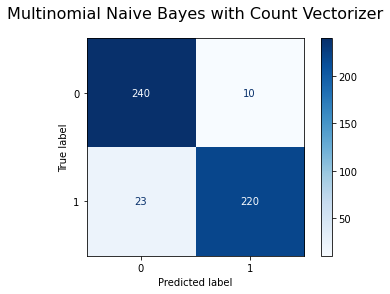

In [1374]:
plt.figure(figsize=(12,5))
plot_confusion_matrix(gs, X_test, y_test, cmap='Blues', values_format='d');
plt.title('Multinomial Naive Bayes with Count Vectorizer', fontsize=16, pad=20)
plt.savefig('../images/fig18.jpg', dpi=800);

### Multinomial Naive Bayes with TfidfVectorizer.

In [1496]:
pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('nb', MultinomialNB())
])

In [1497]:
pipe_params = {'tvec__max_features':[4000, 5000, 6000],
               'tvec__min_df':[2, 3, 4],
               'tvec__max_df':[.85, .90],
               'tvec__ngram_range':[(1,1), (1,2)]
    
}

In [1498]:
gs = GridSearchCV(pipe,
                  pipe_params,
                  cv=cv_folds, verbose=1,
                  n_jobs=4)

In [1499]:
%time gs.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.9s


CPU times: user 578 ms, sys: 113 ms, total: 692 ms
Wall time: 12.9 s


[Parallel(n_jobs=4)]: Done 180 out of 180 | elapsed:   12.8s finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('nb', MultinomialNB())]),
             n_jobs=4,
             param_grid={'tvec__max_df': [0.85, 0.9],
                         'tvec__max_features': [4000, 5000, 6000],
                         'tvec__min_df': [2, 3, 4],
                         'tvec__ngram_range': [(1, 1), (1, 2)]},
             verbose=1)

In [1500]:
gs.best_params_

{'tvec__max_df': 0.85,
 'tvec__max_features': 5000,
 'tvec__min_df': 2,
 'tvec__ngram_range': (1, 1)}

#### Coefficients.

In [1501]:
model_coef = gs.best_estimator_.named_steps['nb'].coef_
model_feat = gs.best_estimator_.named_steps['tvec'].get_feature_names()

coef_df = pd.DataFrame(model_coef, columns=model_feat)

coef_df.T.sort_values(by=0).head(10)

,0
disagree,-9.219683
borrowed,-9.219683
boston,-9.219683
utm,-9.219683
notebook,-9.219683
bothered,-9.219683
sport,-9.219683
texting,-9.219683
roof,-9.219683
usa,-9.219683


In [1380]:
scores_df['NB with TFIDF'] = get_scores(gs)
scores_df['NB with TFIDF']

best score     0.9506
train score    0.9797
test score     0.9189
sensitivity    0.9095
specificity    0.9280
precision      0.9247
accuracy       0.9189
Name: NB with TFIDF, dtype: float64

<Figure size 864x360 with 0 Axes>

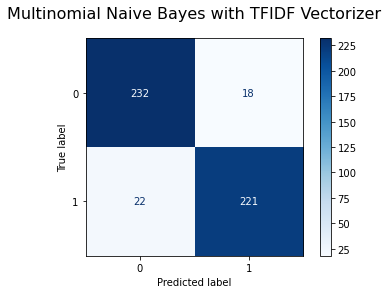

In [1381]:
plt.figure(figsize=(12,5))
plot_confusion_matrix(gs, X_test, y_test, cmap='Blues', values_format='d');
plt.title('Multinomial Naive Bayes with TFIDF Vectorizer', fontsize=16, pad=20)
plt.savefig('../images/fig20.jpg', dpi=800);

### Logistic Regression with CountVectorizer.

In [1502]:
pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('lr', LogisticRegression())
])

In [1503]:
pipe_params = {'cvec__max_features':[4000, 5000, 6000],
               'cvec__min_df':[2, 3],
               'cvec__max_df':[.90],
               'cvec__ngram_range':[(1,1), (1,2)],
               'lr__max_iter' : [1000, 2000, 3000],
               'lr__C' : [1, 2],
               'lr__solver' : ['liblinear', 'lbfgs']
    
}

In [1504]:
gs = GridSearchCV(pipe,
                  pipe_params,
                  cv=cv_folds, verbose=1,
                  n_jobs=4)

In [1505]:
%time gs.fit(X_train, y_train)

Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   14.3s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   38.9s
[Parallel(n_jobs=4)]: Done 720 out of 720 | elapsed:  1.1min finished


CPU times: user 2.45 s, sys: 254 ms, total: 2.71 s
Wall time: 1min 8s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('lr', LogisticRegression())]),
             n_jobs=4,
             param_grid={'cvec__max_df': [0.9],
                         'cvec__max_features': [4000, 5000, 6000],
                         'cvec__min_df': [2, 3],
                         'cvec__ngram_range': [(1, 1), (1, 2)], 'lr__C': [1, 2],
                         'lr__max_iter': [1000, 2000, 3000],
                         'lr__solver': ['liblinear', 'lbfgs']},
             verbose=1)

In [1386]:
gs.best_params_

{'cvec__max_df': 0.9,
 'cvec__max_features': 4000,
 'cvec__min_df': 3,
 'cvec__ngram_range': (1, 2),
 'lr__C': 1,
 'lr__max_iter': 1000,
 'lr__solver': 'lbfgs'}

#### Coefficients.

In [1506]:
model_coef = gs.best_estimator_.named_steps['lr'].coef_
model_feat = gs.best_estimator_.named_steps['cvec'].get_feature_names()

coef_df = pd.DataFrame(model_coef, columns=model_feat)

coef_df.T.sort_values(by=0).head(10)
# ignore removed and deleted below

,0
removed,-3.824829
teen,-1.212967
deleted,-1.145014
school,-0.869993
teenager,-0.861181
boys,-0.743924
teenage,-0.646411
life,-0.645150
parents,-0.640428
son,-0.617834


In [1387]:
scores_df['LR with CV'] = get_scores(gs)
scores_df['LR with CV']

best score     0.9297
train score    0.9980
test score     0.9087
sensitivity    0.8930
specificity    0.9240
precision      0.9195
accuracy       0.9087
Name: LR with CV, dtype: float64

<Figure size 864x360 with 0 Axes>

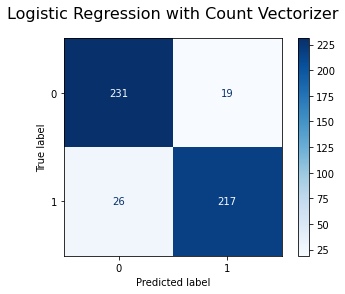

In [1388]:
plt.figure(figsize=(12,5))
plot_confusion_matrix(gs, X_test, y_test, cmap='Blues', values_format='d');
plt.title('Logistic Regression with Count Vectorizer', fontsize=16, pad=20)
plt.savefig('../images/fig25.jpg', dpi=800);

### Logistic Regression with TfidfVectorizer.

In [1507]:
pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('lr', LogisticRegression())
])

In [1508]:
pipe_params = {'tvec__max_features':[4000, 5000, 6000],
               'tvec__min_df':[2, 3, 4],
               'tvec__max_df':[.85, .90],
               'tvec__ngram_range':[(1,1), (1,2)],
               'lr__max_iter' : [1000, 2000, 3000],
               'lr__C' : [1, 2],
               'lr__solver' : ['liblinear', 'lbfgs']
    
}

In [1509]:
gs = GridSearchCV(pipe,
                  pipe_params,
                  cv=cv_folds, verbose=1,
                  n_jobs=4)

In [1510]:
%time gs.fit(X_train, y_train)

Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.8s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   14.2s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   31.9s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:   56.9s
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:  1.5min
[Parallel(n_jobs=4)]: Done 1792 tasks      | elapsed:  2.2min


CPU times: user 5.85 s, sys: 687 ms, total: 6.53 s
Wall time: 2min 36s


[Parallel(n_jobs=4)]: Done 2160 out of 2160 | elapsed:  2.6min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('lr', LogisticRegression())]),
             n_jobs=4,
             param_grid={'lr__C': [1, 2], 'lr__max_iter': [1000, 2000, 3000],
                         'lr__solver': ['liblinear', 'lbfgs'],
                         'tvec__max_df': [0.85, 0.9],
                         'tvec__max_features': [4000, 5000, 6000],
                         'tvec__min_df': [2, 3, 4],
                         'tvec__ngram_range': [(1, 1), (1, 2)]},
             verbose=1)

In [1511]:
gs.best_params_

{'lr__C': 2,
 'lr__max_iter': 1000,
 'lr__solver': 'lbfgs',
 'tvec__max_df': 0.85,
 'tvec__max_features': 4000,
 'tvec__min_df': 2,
 'tvec__ngram_range': (1, 1)}

#### Coefficients.

In [1512]:
model_coef = gs.best_estimator_.named_steps['lr'].coef_
model_feat = gs.best_estimator_.named_steps['tvec'].get_feature_names()

coef_df = pd.DataFrame(model_coef, columns=model_feat)

coef_df.T.sort_values(by=0).head(10)
# ignore removed below

,0
removed,-8.973728
school,-3.713542
teen,-3.345202
her,-2.636715
teenager,-2.493793
son,-2.310702
daughter,-2.217570
friends,-2.033781
parents,-2.019576
they,-1.959299


In [1394]:
scores_df['LR with TFIDF'] = get_scores(gs)
scores_df['LR with TFIDF']

best score     0.9432
train score    0.9885
test score     0.9209
sensitivity    0.9136
specificity    0.9280
precision      0.9250
accuracy       0.9209
Name: LR with TFIDF, dtype: float64

<Figure size 864x360 with 0 Axes>

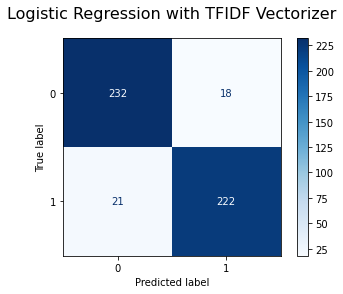

In [1395]:
plt.figure(figsize=(12,5))
plot_confusion_matrix(gs, X_test, y_test, cmap='Blues', values_format='d');
plt.title('Logistic Regression with TFIDF Vectorizer', fontsize=16, pad=20)
plt.savefig('../images/fig19.jpg', dpi=800);

### Random Forest Classifier with CountVectorizer.

In [1396]:
pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('rf', RandomForestClassifier())
])

In [1397]:
pipe_params = {'cvec__max_features':[2000, 3000, 4000],
               'cvec__min_df':[2, 3],
               'cvec__max_df':[.90, .95],
               'cvec__ngram_range':[(1,1), (1,2)],
               'rf__n_estimators' : [75,100],
               'rf__max_features' : [None, 'auto'],
               'rf__max_depth' : [5, 6]
}

In [1398]:
gs = GridSearchCV(pipe,
                  pipe_params,
                  cv=cv_folds, verbose=1,
                  n_jobs=4)

In [1399]:
%time gs.fit(X_train, y_train)

Fitting 5 folds for each of 192 candidates, totalling 960 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   11.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  1.0min
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  2.5min
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:  4.1min
[Parallel(n_jobs=4)]: Done 960 out of 960 | elapsed:  5.0min finished


CPU times: user 3.63 s, sys: 399 ms, total: 4.03 s
Wall time: 4min 59s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('rf', RandomForestClassifier())]),
             n_jobs=4,
             param_grid={'cvec__max_df': [0.9, 0.95],
                         'cvec__max_features': [2000, 3000, 4000],
                         'cvec__min_df': [2, 3],
                         'cvec__ngram_range': [(1, 1), (1, 2)],
                         'rf__max_depth': [5, 6],
                         'rf__max_features': [None, 'auto'],
                         'rf__n_estimators': [75, 100]},
             verbose=1)

In [1400]:
gs.best_params_

{'cvec__max_df': 0.9,
 'cvec__max_features': 3000,
 'cvec__min_df': 3,
 'cvec__ngram_range': (1, 2),
 'rf__max_depth': 6,
 'rf__max_features': 'auto',
 'rf__n_estimators': 100}

In [1401]:
scores_df['RF with CV'] = get_scores(gs)
scores_df['RF with CV']

best score     0.8939
train score    0.9432
test score     0.8844
sensitivity    0.8683
specificity    0.9000
precision      0.8941
accuracy       0.8844
Name: RF with CV, dtype: float64

<Figure size 864x360 with 0 Axes>

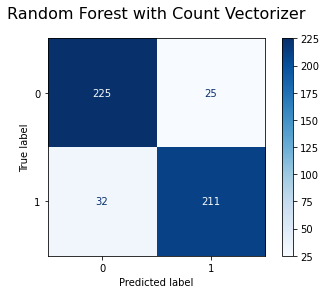

In [1402]:
plt.figure(figsize=(12,5))
plot_confusion_matrix(gs, X_test, y_test, cmap='Blues', values_format='d');
plt.title('Random Forest with Count Vectorizer', fontsize=16, pad=20)
plt.savefig('../images/fig24.jpg', dpi=800);

### Random Forest Classifier with TfidfVectorizer.

In [1403]:
pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('rf', RandomForestClassifier())
])

In [1404]:
pipe_params = {'tvec__max_features':[5000, 6000],
               'tvec__min_df':[2, 3],
               'tvec__max_df':[.85, .90],
               'tvec__ngram_range':[(1,1)],
               'rf__n_estimators' : [75,100,125],
               'rf__max_features' : [None, 'auto'],
               'rf__max_depth' : [None, 5, 6]
}

In [1405]:
gs = GridSearchCV(pipe,
                  pipe_params,
                  cv=cv_folds, verbose=1,
                  n_jobs=4)

In [1406]:
%time gs.fit(X_train, y_train)

Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.1min
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  4.2min
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  5.9min
[Parallel(n_jobs=4)]: Done 720 out of 720 | elapsed:  7.8min finished


CPU times: user 2.92 s, sys: 284 ms, total: 3.2 s
Wall time: 7min 50s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('rf', RandomForestClassifier())]),
             n_jobs=4,
             param_grid={'rf__max_depth': [None, 5, 6],
                         'rf__max_features': [None, 'auto'],
                         'rf__n_estimators': [75, 100, 125],
                         'tvec__max_df': [0.85, 0.9],
                         'tvec__max_features': [5000, 6000],
                         'tvec__min_df': [2, 3],
                         'tvec__ngram_range': [(1, 1)]},
             verbose=1)

In [1407]:
gs.best_params_

{'rf__max_depth': None,
 'rf__max_features': 'auto',
 'rf__n_estimators': 100,
 'tvec__max_df': 0.9,
 'tvec__max_features': 6000,
 'tvec__min_df': 3,
 'tvec__ngram_range': (1, 1)}

In [1408]:
scores_df['RF with TFIDF'] = get_scores(gs)
scores_df['RF with TFIDF']

best score     0.9108
train score    1.0000
test score     0.8966
sensitivity    0.9506
specificity    0.8440
precision      0.8556
accuracy       0.8966
Name: RF with TFIDF, dtype: float64

<Figure size 864x360 with 0 Axes>

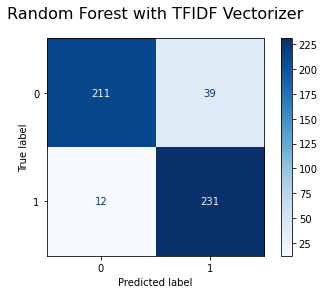

In [1409]:
plt.figure(figsize=(12,5))
plot_confusion_matrix(gs, X_test, y_test, cmap='Blues', values_format='d');
plt.title('Random Forest with TFIDF Vectorizer', fontsize=16, pad=20)
plt.savefig('../images/fig21.jpg', dpi=800);

### SVC with CountVectorizer.

In [1410]:
pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('svc', SVC())
])

In [1411]:
pipe_params = {'cvec__max_features':[4000, 5000, 6000],
               'cvec__min_df':[2, 3],
               'cvec__max_df':[.90],
               'cvec__ngram_range':[(1,1), (1,2)],
               'svc__C' : [1, 2],
               'svc__kernel' : ['rbf', 'poly'],
               'svc__max_iter' : [2000, 5000]
}

In [1412]:
gs = GridSearchCV(pipe,
                  pipe_params,
                  cv=cv_folds, verbose=1,
                  n_jobs=4)

In [1413]:
%time gs.fit(X_train, y_train)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   11.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   57.6s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  2.3min
[Parallel(n_jobs=4)]: Done 480 out of 480 | elapsed:  2.6min finished


CPU times: user 2.63 s, sys: 207 ms, total: 2.83 s
Wall time: 2min 35s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('svc', SVC())]),
             n_jobs=4,
             param_grid={'cvec__max_df': [0.9],
                         'cvec__max_features': [4000, 5000, 6000],
                         'cvec__min_df': [2, 3],
                         'cvec__ngram_range': [(1, 1), (1, 2)],
                         'svc__C': [1, 2], 'svc__kernel': ['rbf', 'poly'],
                         'svc__max_iter': [2000, 5000]},
             verbose=1)

In [1414]:
gs.best_params_

{'cvec__max_df': 0.9,
 'cvec__max_features': 4000,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 1),
 'svc__C': 2,
 'svc__kernel': 'rbf',
 'svc__max_iter': 2000}

In [1415]:
scores_df['SVC with CV'] = get_scores(gs)
scores_df['SVC with CV']

best score     0.8783
train score    0.9675
test score     0.8905
sensitivity    0.8848
specificity    0.8960
precision      0.8921
accuracy       0.8905
Name: SVC with CV, dtype: float64

<Figure size 864x360 with 0 Axes>

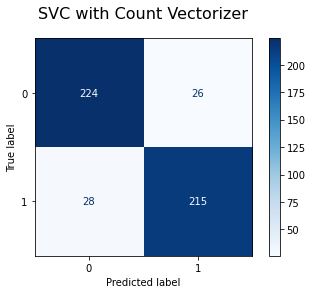

In [1416]:
plt.figure(figsize=(12,5))
plot_confusion_matrix(gs, X_test, y_test, cmap='Blues', values_format='d');
plt.title('SVC with Count Vectorizer', fontsize=16, pad=20)
plt.savefig('../images/fig23.jpg', dpi=800);

### SVC with TfidfVectorizer.

In [1417]:
pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('svc', SVC())
])

In [1418]:
pipe_params = {'tvec__max_features':[5000, 6000],
               'tvec__min_df':[2, 3],
               'tvec__max_df':[.85, .90],
               'tvec__ngram_range':[(1,1), (1,2)],
               'svc__C' : [1, 2],
               'svc__kernel' : ['rbf', 'poly'],
               'svc__max_iter' : [2000, 5000]
}

In [1419]:
gs = GridSearchCV(pipe,
                  pipe_params,
                  cv=cv_folds, verbose=1,
                  n_jobs=4)

In [1420]:
%time gs.fit(X_train, y_train)

Fitting 5 folds for each of 128 candidates, totalling 640 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   17.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  1.3min
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  2.8min
[Parallel(n_jobs=4)]: Done 640 out of 640 | elapsed:  4.1min finished


CPU times: user 3.28 s, sys: 261 ms, total: 3.54 s
Wall time: 4min 5s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('svc', SVC())]),
             n_jobs=4,
             param_grid={'svc__C': [1, 2], 'svc__kernel': ['rbf', 'poly'],
                         'svc__max_iter': [2000, 5000],
                         'tvec__max_df': [0.85, 0.9],
                         'tvec__max_features': [5000, 6000],
                         'tvec__min_df': [2, 3],
                         'tvec__ngram_range': [(1, 1), (1, 2)]},
             verbose=1)

In [1421]:
gs.best_params_

{'svc__C': 2,
 'svc__kernel': 'rbf',
 'svc__max_iter': 2000,
 'tvec__max_df': 0.85,
 'tvec__max_features': 5000,
 'tvec__min_df': 2,
 'tvec__ngram_range': (1, 1)}

In [1423]:
scores_df['SVC with TFIDF'] = get_scores(gs)
scores_df['SVC with TFIDF']

best score     0.9446
train score    1.0000
test score     0.9270
sensitivity    0.9259
specificity    0.9280
precision      0.9259
accuracy       0.9270
Name: SVC with TFIDF, dtype: float64

In [ ]:
plt.figure(figsize=(12,5))
plot_confusion_matrix(gs, X_test, y_test, cmap='Blues', values_format='d');
plt.title('SVC with TFIDF Vectorizer', fontsize=16, pad=20)
plt.savefig('../images/fig22.jpg', dpi=800);

### Print out the scores for each model for comparison.

In [1424]:
print(tabulate(scores_df, tablefmt="pipe", headers="keys"))

|             |   NB with CV |   NB with TFIDF |   LR with CV |   LR with TFIDF |   RF with CV |   RF with TFIDF |   SVC with CV |   SVC with TFIDF |
|:------------|-------------:|----------------:|-------------:|----------------:|-------------:|----------------:|--------------:|-----------------:|
| best score  |       0.95   |          0.9506 |       0.9297 |          0.9432 |       0.8939 |          0.9108 |        0.8783 |           0.9446 |
| train score |       0.9784 |          0.9797 |       0.998  |          0.9885 |       0.9432 |          1      |        0.9675 |           1      |
| test score  |       0.9331 |          0.9189 |       0.9087 |          0.9209 |       0.8844 |          0.8966 |        0.8905 |           0.927  |
| sensitivity |       0.9053 |          0.9095 |       0.893  |          0.9136 |       0.8683 |          0.9506 |        0.8848 |           0.9259 |
| specificity |       0.96   |          0.928  |       0.924  |          0.928  |       0.9    |    

|             |   NB with CV |   NB with TFIDF |   LR with CV |   LR with TFIDF |   RF with CV |   RF with TFIDF |   SVC with CV |   SVC with TFIDF |
|:------------|-------------:|----------------:|-------------:|----------------:|-------------:|----------------:|--------------:|-----------------:|
| best score  |       0.95   |          0.9506 |       0.9297 |          0.9432 |       0.8939 |          0.9108 |        0.8783 |           0.9446 |
| train score |       0.9784 |          0.9797 |       0.998  |          0.9885 |       0.9432 |          1      |        0.9675 |           1      |
| test score  |       0.9331 |          0.9189 |       0.9087 |          0.9209 |       0.8844 |          0.8966 |        0.8905 |           0.927  |
| sensitivity |       0.9053 |          0.9095 |       0.893  |          0.9136 |       0.8683 |          0.9506 |        0.8848 |           0.9259 |
| specificity |       0.96   |          0.928  |       0.924  |          0.928  |       0.9    |          0.844  |        0.896  |           0.928  |
| precision   |       0.9565 |          0.9247 |       0.9195 |          0.925  |       0.8941 |          0.8556 |        0.8921 |           0.9259 |
| accuracy    |       0.9331 |          0.9189 |       0.9087 |          0.9209 |       0.8844 |          0.8966 |        0.8905 |           0.927  |